In [1]:
from tqdm import tqdm
from glob import glob
from matplotlib.colors import ListedColormap
from EmbedSeg.utils.preprocess_data import extract_data, split_train_val, split_train_crops, get_data_properties
from EmbedSeg.utils.generate_crops import *
from EmbedSeg.utils.visualize import visualize_many_crops, visualize_3d
from EmbedSeg.utils.create_dicts import create_dataset_dict, create_model_dict, create_loss_dict, create_configs, create_test_configs_dict

from EmbedSeg.train import begin_training
from EmbedSeg.test import begin_evaluating
import json, tifffile, numpy as np, os, torch
%matplotlib inline

### Download data

>The images and corresponding masks are downloaded from an external url, specified by `zip_url` to the path specified by the variables `data_dir` and `project_name`, using `extract_data` function. 
Next, the `train` directories are split into `train` and `val` using `split_train_val`, but for now we don't transfer any images into the `val` directory (`subset = 0.0`)

In [2]:
data_dir = '../../data'
project_name = 'Mouse-Skull-Nuclei-CBG-sliced'

In [3]:
extract_data(
    zip_url = 'https://github.com/juglab/EmbedSeg/releases/download/v0.1.0/Mouse-Skull-Nuclei-CBG.zip',
    data_dir = data_dir,
    project_name = project_name,
)

Zip file was downloaded and extracted before!


In [4]:
split_train_val(
    data_dir = data_dir,
    project_name = project_name, 
    train_val_name = 'train',
    subset = 0.0)

Train-Val-Test Images/Masks copied to ../../data/Mouse-Skull-Nuclei-CBG-sliced


### Specify desired centre location for spatial embedding of pixels

>Interior pixels of an object instance can either be embedded at the `medoid` or the `centroid`.

In [4]:
center = 'medoid' # 'medoid', 'centroid'

### Calculate some dataset specific properties

>In the next cell, we will calculate properties of the data such as `min_object_size`, `foreground_weight` etc. 
We can also specify some properties, for example, set `data_properties_dir['data_type']='16-bit'` if the images are of datatype `unsigned 16 bit` and `data_properties_dir['data_type']='8-bit'` if the images are of datatype `unsigned 8 bit`.

In [5]:
data_properties_dir = get_data_properties(data_dir, project_name, train_val_name=['train'], 
                                          test_name=['test'], mode='3d_sliced')

data_properties_dir['data_type']='16-bit'
data_properties_dir['pixel_size_x_microns']=0.073 # set equal to voxel size (microns) in x dimension
data_properties_dir['pixel_size_y_microns']=0.073 # set equal to voxel size (microns) in y dimension
data_properties_dir['pixel_size_z_microns']=0.20 # set equal to voxel size (microns) in z dimension
data_type, foreground_weight, n_z, n_y, n_x, pixel_size_z_microns, pixel_size_x_microns, min_object_size = data_properties_dir['data_type'], float(data_properties_dir['foreground_weight']), int(data_properties_dir['n_z']), int(data_properties_dir['n_y']), int(data_properties_dir['n_x']), float(data_properties_dir['pixel_size_z_microns']), float(data_properties_dir['pixel_size_x_microns']), int(data_properties_dir['min_object_size'])

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.59it/s]


Foreground weight of the `Mouse-Skull-Nuclei-CBG-sliced` dataset set equal to 10.000


100%|█████████████████████████████████████████████| 2/2 [00:22<00:00, 11.26s/it]


Minimum object size of the `Mouse-Skull-Nuclei-CBG-sliced` dataset is equal to 662
Mean object size of the `Mouse-Skull-Nuclei-CBG-sliced` dataset is equal to 107009.20666666667
Maximum object size of the `Mouse-Skull-Nuclei-CBG-sliced` dataset is equal to 334765
Average object size of the `Mouse-Skull-Nuclei-CBG-sliced` dataset along `x` is equal to 70.073
Std. dev object size of the `Mouse-Skull-Nuclei-CBG-sliced` dataset along `x` is equal to 30.091
Average object size of the `Mouse-Skull-Nuclei-CBG-sliced` dataset along `y` is equal to 115.540
Std. dev object size of the `Mouse-Skull-Nuclei-CBG-sliced` dataset along `y` is equal to 48.412
Average object size of the `Mouse-Skull-Nuclei-CBG-sliced` dataset along `z` is equal to 43.407
Std. dev object size of the `Mouse-Skull-Nuclei-CBG-sliced` dataset along `z` is equal to 20.293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 91.87it/s]


Tile size of the `Mouse-Skull-Nuclei-CBG-sliced` dataset set equal to (512, 512)


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.90it/s]

Average background intensity of the `Mouse-Skull-Nuclei-CBG-sliced` dataset set equal to 124.718


### Specify cropping configuration parameters

>Images and the corresponding masks are cropped into patches centred around an object instance, which are pre-saved prior to initiating the training. Note that the cropped images, masks and center-images would be saved at the path specified by `crops_dir` (The parameter `crops_dir` is set to ```./crops``` by default, which creates a directory at the same location as this notebook).  
Note that we automatically calculate  the `crop_size` by using the `avg_object_size` and `std_object_size` through the relation:  
$\text{crop_size_i} = \text{avg_obj_size_i} + \text{n_sigma} \times \text{std_obj_size_i}$ where $i \in \{x,y\}$.  

In [6]:
n_sigma = 5

In [7]:
def round_up_8(x):
    return (x.astype(int)+7) & (-8)

In [8]:
crops_dir = './crops'
crop_size_z = np.max([
    round_up_8(data_properties_dir['avg_object_size_z'] + n_sigma*data_properties_dir['stdev_object_size_z']),
    round_up_8(data_properties_dir['avg_object_size_y'] + n_sigma*data_properties_dir['stdev_object_size_y']),
    round_up_8(data_properties_dir['avg_object_size_x'] + n_sigma*data_properties_dir['stdev_object_size_x'])])
crop_size_x = crop_size_z
crop_size_y = crop_size_z
print("Crop size in x, y and z will be set equal to {}".format(crop_size_z))


Crop size in x, y and z will be set equal to 360


In [9]:
anisotropy_factor = data_properties_dir['pixel_size_z_microns']/data_properties_dir['pixel_size_x_microns']
print("Data anisotropy factor is {:.3f}".format(anisotropy_factor))

Data anisotropy factor is 2.740


### Generate Crops

>Images are normalized using `min-max-percentile` scheme (by default) and then cropped and saved using the `process_3d_sliced` method. Other options for normalization are `absolute` and `mean-std`.  
Here, `data_subset` defines the directory which is processed. 

In [10]:
norm = 'min-max-percentile' # min-max-percentile, absolute, mean-std

In [12]:
data_subsets = ['train'] 
for data_subset in data_subsets:
    image_dir = os.path.join(data_dir, project_name, data_subset, 'images')
    instance_dir = os.path.join(data_dir, project_name, data_subset, 'masks')
    image_names = sorted(glob(os.path.join(image_dir, '*.tif'))) 
    instance_names = sorted(glob(os.path.join(instance_dir, '*.tif')))  
    for i in tqdm(np.arange(len(image_names))):
        process_3d_sliced(image_names[i], instance_names[i], os.path.join(crops_dir, project_name), data_subset, 
                crop_size_x = crop_size_x, crop_size_y = crop_size_y, crop_size_z = crop_size_z,
                center = center, anisotropy_factor = anisotropy_factor, norm=norm, data_type = data_properties_dir['data_type'],  
                          fraction_max_ids = 0.02)
    print("Cropping of images, instances and centre_images for data_subset = `{}` done!".format(data_subset))

  0%|                                                     | 0/2 [00:00<?, ?it/s]

Created new directory : ./crops/Mouse-Skull-Nuclei-CBG-sliced/train/images/
Created new directory : ./crops/Mouse-Skull-Nuclei-CBG-sliced/train/masks/
Created new directory : ./crops/Mouse-Skull-Nuclei-CBG-sliced/train/center-medoid/


100%|████████████████████████████████████████████| 2/2 [15:26<00:00, 463.09s/it]

Cropping of images, instances and centre_images for data_subset = `train` done!


<div class="alert alert-block alert-info"> <b> Why did we choose min-max-percentile? </b> For example, would longer training help? <br>
    Go above in the notebook and <u>resume training</u>  from the last checkpoint  </div>

### Keep some crops for validation

>Since there were only $2$ train image volumes, instead of reserving a subset of image volumes for validation (as is general practice),  we reserve some of the crops generated from the train image volumes for validation.

In [13]:
split_train_crops(project_name = project_name, center = center, crops_dir = crops_dir, subset = 0.15)

Created new directory : ./crops/Mouse-Skull-Nuclei-CBG-sliced/val/images/
Created new directory : ./crops/Mouse-Skull-Nuclei-CBG-sliced/val/masks/
Created new directory : ./crops/Mouse-Skull-Nuclei-CBG-sliced/val/center-medoid/
Val Images/Masks/Center-medoid-image crops saved at ./crops/Mouse-Skull-Nuclei-CBG-sliced/val


### Visualize cropped images, corresponding ground truth masks and object center images 

>Some of these cropped images and their label masks are visualized. The label masks are colored with a glasbey-style color map stored in `new_cmap`.

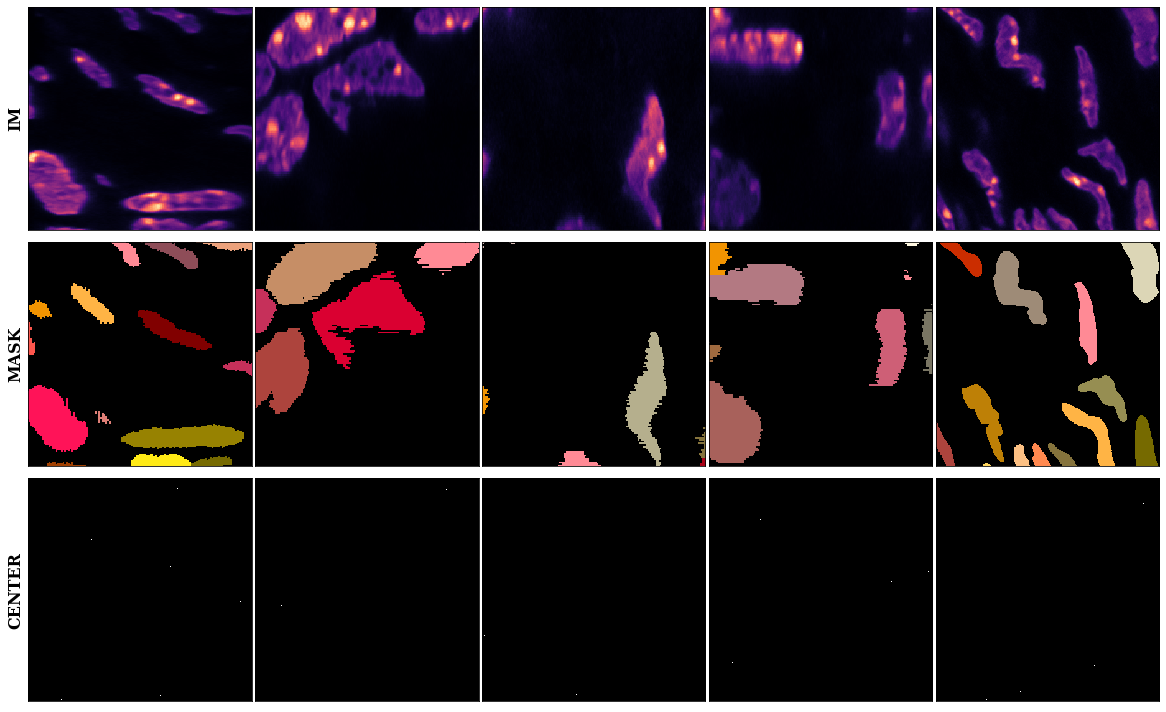

In [11]:
new_cmap = np.load('../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 
visualize_many_crops(data_dir=crops_dir, project_name=project_name, train_val_dir='val', center=center, n_images=5, new_cmp=new_cmap)

### Specify training dataset-related parameters

>We create a `train_dataset_dict` dictionary using the crops extracted from the train images and masks 

In [12]:
train_dataset_dict = create_dataset_dict(data_dir = crops_dir, 
                                         project_name = project_name,  
                                         center = center, 
                                         size = len(os.listdir(os.path.join(crops_dir, project_name, 'train', 'images'))), 
                                         batch_size = 16, 
                                         type = 'train')

`train_dataset_dict` dictionary successfully created with: 
 -- train images accessed from ./crops/Mouse-Skull-Nuclei-CBG-sliced/train/images, 
 -- number of images per epoch equal to 918, 
 -- batch size set at 16, 
 -- virtual batch multiplier set as 1, 
 -- one_hot set as False, 


### Specify val dataset-related parameters

>We create a `val_dataset_dict` dictionary using the crops extracted from the val images and masks 

In [13]:
val_dataset_dict = create_dataset_dict(data_dir = crops_dir, 
                                       project_name = project_name, 
                                       center = center, 
                                       size = len(os.listdir(os.path.join(crops_dir, project_name, 'val', 'images'))), 
                                       batch_size = 16, 
                                       type ='val',)

`val_dataset_dict` dictionary successfully created with: 
 -- val images accessed from ./crops/Mouse-Skull-Nuclei-CBG-sliced/val/images, 
 -- number of images per epoch equal to 162, 
 -- batch size set at 16, 
 -- virtual batch multiplier set as 1, 
 -- one_hot set as False, 


### Specify model-related parameters

>Set the `input_channels` attribute equal to the number of channels in the input images. 
In the cell after this one, a `model_dataset_dict` and a `loss_dict` dictionary is created.

In [14]:
model_dict = create_model_dict(input_channels = 1)
loss_dict = create_loss_dict()

`model_dict` dictionary successfully created with: 
 -- num of classes equal to 1, 
 -- input channels equal to [4, 1], 
 -- name equal to branched_erfnet
`loss_dict` dictionary successfully created with: 
 -- foreground weight equal to 10.000, 
 -- w_inst equal to 1, 
 -- w_var equal to 10, 
 -- w_seed equal to 1


### Specify the duration of training by setting `n_epochs`

In the cell after this one, a `configs` dictionary is created.  
The model weights are saved by default at `experiment/Mouse-Skull-Nuclei-CBG-sliced-demo`

In [15]:
n_epochs = 20

In [16]:
configs = create_configs(save_dir = os.path.join('experiment', project_name+'-'+'demo'), 
                         n_epochs=n_epochs,
                         resume_path=None,
                         n_y = n_y, 
                         n_x = n_x,)

`configs` dictionary successfully created with: 
 -- n_epochs equal to 20, 
 -- display equal to False, 
 -- save_dir equal to experiment/Mouse-Skull-Nuclei-CBG-sliced-demo, 
 -- n_z equal to None, 
 -- n_y equal to 512, 
 -- n_x equal to 512, 
 -- one_hot equal to False, 


### Begin training!

>We input the dictionaries created above to the `begin_training` function 

In [17]:
%matplotlib Agg
begin_training(train_dataset_dict, val_dataset_dict, model_dict, loss_dict, configs)

2-D `train` dataloader created! Accessing data from ./crops/Mouse-Skull-Nuclei-CBG-sliced/train/
Number of images in `train` directory is 918
Number of instances in `train` directory is 918
Number of center images in `train` directory is 918
*************************
2-D `val` dataloader created! Accessing data from ./crops/Mouse-Skull-Nuclei-CBG-sliced/val/
Number of images in `val` directory is 162
Number of instances in `val` directory is 162
Number of center images in `val` directory is 162
*************************
Creating Branched Erfnet with [4, 1] outputs
Initialize last layer with size:  torch.Size([16, 4, 2, 2])
*************************
Created spatial emb loss function with: n_sigma: 2, foreground_weight: 10
*************************
Created logger with keys:  ('train', 'val', 'iou')
Starting epoch 0
learning rate: 0.0005


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.61it/s]


===> train loss: 1.55
===> val loss: 1.30, val iou: 0.43
=> saving checkpoint
Starting epoch 1
learning rate: 0.0004977494364660346


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.50it/s]


===> train loss: 1.19
===> val loss: 1.17, val iou: 0.47
=> saving checkpoint
Starting epoch 2
learning rate: 0.0004954977417064171


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.59it/s]


===> train loss: 1.02
===> val loss: 0.89, val iou: 0.65
=> saving checkpoint
Starting epoch 3
learning rate: 0.0004932449094349202


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


===> train loss: 0.85
===> val loss: 0.77, val iou: 0.71
=> saving checkpoint
Starting epoch 4
learning rate: 0.0004909909332982877


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.58it/s]


===> train loss: 0.72
===> val loss: 0.72, val iou: 0.71
=> saving checkpoint
Starting epoch 5
learning rate: 0.0004887358068751748


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


===> train loss: 0.66
===> val loss: 0.67, val iou: 0.74
=> saving checkpoint
Starting epoch 6
learning rate: 0.0004864795236750653


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.50it/s]


===> train loss: 0.63
===> val loss: 0.61, val iou: 0.77
=> saving checkpoint
Starting epoch 7
learning rate: 0.00048422207713716544


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.60it/s]


===> train loss: 0.61
===> val loss: 0.58, val iou: 0.78
=> saving checkpoint
Starting epoch 8
learning rate: 0.00048196346062927547


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


===> train loss: 0.58
===> val loss: 0.57, val iou: 0.77
=> saving checkpoint
Starting epoch 9
learning rate: 0.00047970366744663594


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.42it/s]


===> train loss: 0.57
===> val loss: 0.62, val iou: 0.77
=> saving checkpoint
Starting epoch 10
learning rate: 0.00047744269081074987


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.55it/s]


===> train loss: 0.56
===> val loss: 0.56, val iou: 0.78
=> saving checkpoint
Starting epoch 11
learning rate: 0.0004751805238681794


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


===> train loss: 0.56
===> val loss: 0.54, val iou: 0.79
=> saving checkpoint
Starting epoch 12
learning rate: 0.000472917159689316


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.55it/s]


===> train loss: 0.54
===> val loss: 0.54, val iou: 0.78
=> saving checkpoint
Starting epoch 13
learning rate: 0.00047065259126712457


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.54it/s]


===> train loss: 0.52
===> val loss: 0.50, val iou: 0.80
=> saving checkpoint
Starting epoch 14
learning rate: 0.00046838681151585874


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.59it/s]


===> train loss: 0.52
===> val loss: 0.54, val iou: 0.78
=> saving checkpoint
Starting epoch 15
learning rate: 0.0004661198132697498


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.30it/s]


===> train loss: 0.52
===> val loss: 0.52, val iou: 0.79
=> saving checkpoint
Starting epoch 16
learning rate: 0.0004638515892816641


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.60it/s]


===> train loss: 0.51
===> val loss: 0.54, val iou: 0.78
=> saving checkpoint
Starting epoch 17
learning rate: 0.00046158213222173284


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.60it/s]


===> train loss: 0.51
===> val loss: 0.55, val iou: 0.78
=> saving checkpoint
Starting epoch 18
learning rate: 0.0004593114346759497


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.52it/s]


===> train loss: 0.53
===> val loss: 0.53, val iou: 0.79
=> saving checkpoint
Starting epoch 19
learning rate: 0.00045703948914473726


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.58it/s]


===> train loss: 0.50
===> val loss: 0.50, val iou: 0.80
=> saving checkpoint


### Evaluate using your trained model weights 

>Use the model trained by you for $20$ epochs

In [24]:
checkpoint_path = os.path.join('experiment', project_name+'-'+'demo', 'best_iou_model.pth')

### Set `tta=True` for better inference

> Setting `tta=True` leads to improved performance, but the trained model takes *longer* to predict per image.  
In the cell after this one, a `test_configs` dictionary is created.

In [25]:
tta = True
save_dir = './inference/' + project_name

In [26]:
test_configs = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        tta = tta, 
                                        min_object_size = min_object_size, 
                                        save_dir = save_dir,
                                        norm = norm, 
                                        data_type = data_type,
                                        n_z = n_z,
                                        n_y = n_y,
                                        n_x = n_x,
                                        anisotropy_factor = pixel_size_z_microns/pixel_size_x_microns,
                                        name = '3d_sliced',
                                        )

`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from ../../data/Mouse-Skull-Nuclei-CBG-sliced, 
 -- trained weights accessed from experiment/Mouse-Skull-Nuclei-CBG-sliced-demo/best_iou_model.pth, 
 -- output directory chosen as ./inference/Mouse-Skull-Nuclei-CBG-sliced


### Evaluate on unseen test data

>The `test_configs` dictionary created above, is input to the `begin_evaluating` function.

In [21]:
begin_evaluating(test_configs)

3-D `test` dataloader created! Accessing data from ../../data/Mouse-Skull-Nuclei-CBG-sliced/test/
Number of images in `test` directory is 1
Number of instances in `test` directory is 1
Number of center images in `test` directory is 0
*************************
Creating Branched Erfnet with [4, 1] outputs


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Processing `YX` slices .....


100%|█████████████████████████████████████████| 344/344 [00:32<00:00, 10.74it/s]


Processing `ZX` slices .....


100%|█████████████████████████████████████████| 512/512 [00:46<00:00, 11.06it/s]


Processing `ZY` slices .....


100%|████████████████████████████████████████████| 1/1 [02:17<00:00, 137.16s/it]

Mean Average Precision (AP_dsb) at IOU threshold = 0.5 at seediness threshold = 0.90000, is equal to 0.56364


{'fg_thresh': 0.5, 'AP_dsb_05': 0.5636363636363636}

In [22]:
%matplotlib inline
prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
ground_truth_file_names = sorted(glob(os.path.join(save_dir,'ground-truth','*.tif')))
image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'test', 'images','*.tif')))
seed_file_names = sorted(glob(os.path.join(save_dir, 'seeds','*.tif')))

### Visualize some results on unseen test data

Image filename is X2_right.tif and index is 0


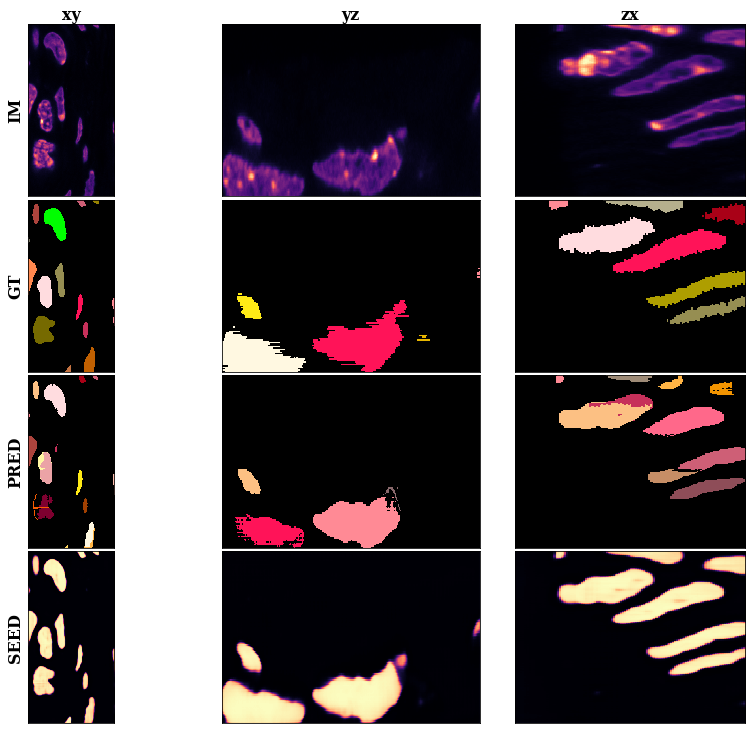

In [23]:
index = 0
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
visualize_3d(image_file_names[index], ground_truth_file_names[index], prediction_file_names[index], seed_file_names[index], new_cmap, anisotropy=pixel_size_z_microns/pixel_size_x_microns)

<div class="alert alert-block alert-info"> <b> How can you improve the model prediction? </b> For example, would longer training help? <br>
    Go above in the notebook and <u>resume training</u>  from the last checkpoint  </div>